This notebook tests the functions in `centralFunctions.ipynb` before deploying them.

In [ ]:
sigAliasList    = ['sig_A', 'sig_h0', 'sig_hch', 'sig_LQ']
sigFilenameList = ['Ato4l_lepFilter_13TeV_filtered.h5', 'hToTauTau_13TeV_PU20_filtered.h5', 'hChToTauNu_13TeV_PU20_filtered.h5', 'leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5']

# Google Drive preliminaries (since we're running on Google Colab)

In [ ]:
#-- "Mount" Google Drive to access data and save files/images --#
# NOTE: If running locally, comment out this cell and change the basePath accordingly
# Reference: https://stackoverflow.com/questions/49031798/when-i-use-google-colaboratory-how-to-save-image-weights-in-my-google-drive
from google.colab import drive
drive.mount('/content/gdrive')

# You will be asked to sign into a Google account and give GoogleColab access

Mounted at /content/gdrive


In [ ]:
# To check that mounting worked, uncomment and run the following. You should see the contents of the directory listed.
! ls '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/Data/'

Ato4l_lepFilter_13TeV_filtered.h5
background_for_training.h5
BlackBox_background_mix.h5
hChToTauNu_13TeV_PU20_filtered.h5
hToTauTau_13TeV_PU20_filtered.h5
leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5
OldBuggedDatasets


In [ ]:
#-- Set base directory and data directory path --#
basePath   = '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/'
dataPath   = 'Data/'

bkgPath    = basePath+dataPath+'background_for_training.h5'
sigPathList = []
for x in sigFilenameList:
  sigPathList.append(basePath+dataPath+x)

# Import libraries

We'll eventually be using the PyOT library to compute Wasserstein distances for now (see [here](https://pythonot.github.io/index.html)). But since this notebook is just visualizing the data we won't use it yet.

In [ ]:
import numpy as np
from numpy.random import RandomState
import numpy.ma as ma

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

import h5py
from numpy.random import Generator, PCG64
from sklearn import metrics
import itertools

# Functions

To keep things tidy, functions are externally defined in `centralFunctions.ipynb`. We run this notebook from here which defines the contained functions as if they were written here.


In [ ]:
%cd /content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/
%run centralFunctions.ipynb

/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 10.7 MB/s eta 0:00:00


# Load data

For more details on the data structure, see [this exploratory notebook](https://colab.research.google.com/drive/138CL8n4gCtramqaaI-i0EUZ7n4f1SWVh?usp=sharing).

In [ ]:
dataDict = {}
dataDict['bkg'] = h5py.File(bkgPath, 'r')

for i in range(len(sigAliasList)):
  alias   = sigAliasList[i]
  sigPath = sigPathList[i]
  dataDict[alias] = h5py.File(sigPath, 'r')

# Get subset of data for testing

In [ ]:
nEvents   = 100

scoreDict = {}

scoreDict['bkgEvents1'] = dataDict['bkg']['Particles'][0:nEvents, :, 0:3]
scoreDict['bkgEvents2'] = dataDict['bkg']['Particles'][nEvents:2*nEvents, :, 0:3]

for alias in sigAliasList:
  scoreDict[alias]      = dataDict[alias]['Particles'][0:nEvents, :, 0:3]

# Test cases

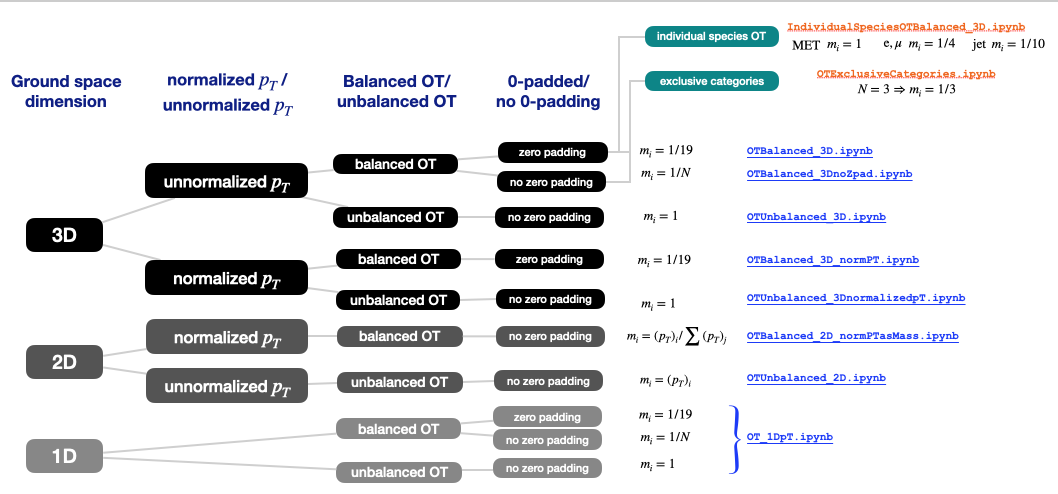



```
   OTSCHEME:  Determines what scheme will be used to calculate the OT distance.
              Note the exact meaning varies somewhat depending on the choice of COSTSCHEME.
              It's a dictionary of 3 booleans cooresponding to whether the PT is normalized,
              whether the OT calculation is balanced, and whether the zero padding should be
              removed. Namely,
              OTSCHEME['normPT']   ==True:  Means that the pT should be normalized;
                                  ==False:  Means that the pT should be unnormalized
              OTSCHEME['balanced'] ==True:  Means that the OT calculation should be balanced;
                                  ==False:  Means that the OT calculation should be unbalanced;
              OTSCHEME['noZeroPad']==True:  Means that the zero padding should be removed;
                                  ==False:  Means that the zero padding should be kept;
 COSTSCHEME:  Determines what scheme will be used to calculate the ground cost matrix. Options are:
              - 1DpT: Ground space is pT only
              - 2D:   Ground space is 2D (eta,phi); note mass is pT
              - 3D:   Ground space is 3D (pT,eta,phi); note mass is uniform
```



## 1D

In [ ]:
COSTSCHEME = '1DpT'  # pT ground space
OTSCHEME = {}
OTSCHEME['normPT']       = False # pT should be unnormalized per event
OTSCHEME['individualOT'] = False # No individual species OT

### Balanced OT

In [ ]:
OTSCHEME['balanced']  = True  # OT calculation is balanced
kwargs                = {}    # No other arguments to pass to function

#### zero padding

In [ ]:
OTSCHEME['noZeroPad'] = False # zero padding is kept

In [ ]:
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

# nEvents = 100 takes about 16s of wall-clock time
# nEvents = 500 takes about 5 mins of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#### no zero padding

In [ ]:
OTSCHEME['noZeroPad'] = True # zero padding is removed

In [ ]:
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

# nEvents = 100 takes about 16s of wall-clock time
# nEvents = 500 takes about 5 mins of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

### Unbalanced OT

In [ ]:
OTSCHEME['balanced']  = False  # OT calculation is unbalanced
kwargs                = {}
kwargs['div']         = 'l2'
kwargs['reg_m']       = 1.

#### no zero padding

In [ ]:
OTSCHEME['noZeroPad'] = True # zero padding is removed

In [ ]:
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

# nEvents = 100 takes about 16s of wall-clock time
# nEvents = 500 takes about 5 mins of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

## 2D

In [ ]:
COSTSCHEME = '2D' # pT ground space
OTSCHEME = {}
OTSCHEME['noZeroPad']    = True # zero padding is removed
OTSCHEME['individualOT'] = False # No individual species OT

### Normalized pT + balanced OT

In [ ]:
OTSCHEME['normPT']    = True # pT is normalized per event
OTSCHEME['balanced']  = True # OT calculation is balanced
kwargs                = {}    # No other arguments to pass to function

In [ ]:
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

# nEvents = 100 takes about 16s of wall-clock time
# nEvents = 500 takes about 5 mins of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

### Unnormalized pT + unbalanced OT

In [ ]:
OTSCHEME['normPT']    = False # pT is unnormalized per event
OTSCHEME['balanced']  = False # OT calculation is unbalanced
kwargs                = {}
kwargs['div']         = 'l2'
kwargs['reg_m']       = 1.

In [ ]:
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

# nEvents = 100 takes about 16s of wall-clock time
# nEvents = 500 takes about 5 mins of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

## 3D

In [ ]:
COSTSCHEME = '3D'  # pT, eta, phi ground space
OTSCHEME = {}
OTSCHEME['individualOT'] = False # No individual species OT

### Normalized pT

In [ ]:
OTSCHEME['normPT']    = True # pT is normalized per event

#### Balanced OT

In [ ]:
OTSCHEME['balanced']  = True # OT calculation is balanced

##### zero padding

In [ ]:
OTSCHEME['noZeroPad'] = False # zero padding is kept

In [ ]:
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

# nEvents = 100 takes about 16s of wall-clock time
# nEvents = 500 takes about 5 mins of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

##### no zero padding

In [ ]:
OTSCHEME['noZeroPad'] = True # zero padding is removed

In [ ]:
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

# nEvents = 100 takes about 16s of wall-clock time
# nEvents = 500 takes about 5 mins of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#### Unbalanced OT

In [ ]:
OTSCHEME['balanced']  = False  # OT calculation is unbalanced
kwargs                = {}
kwargs['div']         = 'l2'
kwargs['reg_m']       = 1.

##### zero padding

In [ ]:
OTSCHEME['noZeroPad'] = False # zero padding is kept

In [ ]:
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

# nEvents = 100 takes about 16s of wall-clock time
# nEvents = 500 takes about 5 mins of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

##### no zero padding

In [ ]:
OTSCHEME['noZeroPad'] = True # zero padding is removed

In [ ]:
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

# nEvents = 100 takes about 16s of wall-clock time
# nEvents = 500 takes about 5 mins of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

### Unormalized pT

In [ ]:
OTSCHEME['normPT']    = False # pT is unnormalized per event

#### Balanced OT

In [ ]:
OTSCHEME['balanced']  = True # OT calculation is balanced

##### zero padding

In [ ]:
OTSCHEME['noZeroPad'] = False # zero padding is kept

In [ ]:
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

# nEvents = 100 takes about 16s of wall-clock time
# nEvents = 500 takes about 5 mins of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

##### no zero padding

In [ ]:
OTSCHEME['noZeroPad'] = True # zero padding is removed

In [ ]:
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

# nEvents = 100 takes about 16s of wall-clock time
# nEvents = 500 takes about 5 mins of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#### Unbalanced OT

In [ ]:
OTSCHEME['balanced']  = False  # OT calculation is unbalanced
kwargs                = {}
kwargs['div']         = 'l2'
kwargs['reg_m']       = 1.

##### zero padding

In [ ]:
OTSCHEME['noZeroPad'] = False # zero padding is kept

In [ ]:
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

# nEvents = 100 takes about 16s of wall-clock time
# nEvents = 500 takes about 5 mins of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

##### no zero padding

In [ ]:
OTSCHEME['noZeroPad'] = True # zero padding is removed

In [ ]:
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

# nEvents = 100 takes about 16s of wall-clock time
# nEvents = 500 takes about 5 mins of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

## Individual Species OT

In [ ]:
COSTSCHEME = '3D'  # pT, eta, phi ground space

OTSCHEME = {}
OTSCHEME['balanced']     = True  # OT calculation is balanced
OTSCHEME['normPT']       = False # pT is unnormalized per event
OTSCHEME['noZeroPad']    = False # zero padding is kept
OTSCHEME['individualOT'] = True # Individual Species OT

kwargs                = {}    # No other arguments to pass to function

In [ ]:
IOTDict = calcIndividualOTScores(scoreDict, sigAliasList, OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs, speciesList=['MET', 'e', 'mu', 'jet'])

In [ ]:
wComboIOTDict = calcWeightedComboOTscores(IOTDict, wList=[1., 1., 1., 1.])